# This is how a neural network learns to add, multiply and compare handwritten digits WITHOUT knowing their values 

<p align="center"> <img src="https://i.dlpng.com/static/png/6906777_preview.png"> </p>   

I described in a [previous post](https://blog.jovian.ai/how-to-train-supervised-machine-learning-algorithms-without-labeled-data-6ebddc01a00f), how useful are autoencoders in  automated labeling. The main property of these networks is their ability to learn features/patterns in the data. This is in fact not specific to autoencoders and can be implemented using other unsupervised techniques, mainly **PCA**.  
The ability to detect and learn features in data can be used in other areas.  

In this post, I will present some applications of convolutional autoencoders:  
- First, a convolutional autoencoder will be trained on **MNIST** data.
- After the training of the encoder and decoder, we will freeze their weights and use them with additional dense layers to "learn" arithmetic operations, namely addition, multiplication and comparison.  
The trick is to *never* explicitly associate the handwritten digits in **MNIST** dataset with their respective labels. We will see that the neural networks will be nevertheless able to reach 97+% accuracy in all cases on unseen data.

The first step of the design is described in the following diagram:
<p align="center"> <img src="https://i.imgur.com/chLUEdp.png"> </p>   

In the second step, we will use the encoder in series with dense layers to perform arithmetic operations: addition, multiplication and comparison. We will train only the dense layer weights, and supply the results of the operations as labels. note that we will not supply the digits values (labels).

<p align="center"> <img src="https://i.imgur.com/s8U8up4.png"> </p> 


# Training an autoencoder on MNIST data

Similar to the previous article, we will use MNIST data in this experiment. The autoencoder will learn the handwritten digits features using 60000 training samples. We import MNIST using *KERAS* library.

In [1]:
#import libraries and setup 
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import logging
logging.getLogger('tensorflow').disabled = True
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, UpSampling2D, Reshape, Concatenate, Input
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=10, restore_best_weights=True)

In [2]:
# import mnist
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print(x_train.shape,y_train.shape)

(60000, 28, 28) (60000,)


We scale the data in the range `[0,1]` and reshape it to *KERAS* format for images (nbr_samples x width x height x channels) 

In [3]:
#normalize data
if x_train.max() >1:
    x_train = x_train / 255
    x_test = x_test / 255

default_shape = x_train.shape
#reshape input data to 1 channel
x_train = x_train.reshape(-1,default_shape[1],default_shape[2],1)
x_test = x_test.reshape(-1,default_shape[1],default_shape[2],1)
image_dim = x_train.shape[1:]

We will implement a similar autoencoder architecture as in [my previous post](https://blog.jovian.ai/how-to-train-supervised-machine-learning-algorithms-without-labeled-data-6ebddc01a00f). It is based on a series of convolutional layers, that will gradually encode the 28x28x1 image (784 pixel) into a 100 elements array, and decode that representation back to the original format. The resulting image -after the training- will hopefully resemble to the original one.

In [4]:
# create an autoencoder / decoder 
encoder = Sequential()
encoder.add(Conv2D(32,kernel_size=(3,3), strides=(1,1),padding='same', activation='selu',input_shape=image_dim))
encoder.add(MaxPooling2D(2,2))
encoder.add(Conv2D(64,kernel_size=(3,3), strides=(1,1),padding='same',activation='selu'))
encoder.add(MaxPooling2D(2,2))
encoder.add(Conv2D(128,kernel_size=(3,3), strides=(1,1),padding='same',activation='selu'))
encoder.add(Flatten())
encoder.add(Dense(100,activation='sigmoid'))
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               6

In [5]:
encoder_out_dim = encoder.layers[-1].output_shape[1:] # dimension of the encoder output

In [6]:
decoder = Sequential()
decoder.add(Dense(6272, activation='sigmoid', input_shape=encoder_out_dim))
decoder.add(Reshape(( 7, 7, 128)))
decoder.add(Conv2D(128,kernel_size=(3,3), strides=(1,1),padding='same', activation='selu'))
decoder.add(UpSampling2D((2,2)))
decoder.add(Conv2D(64,kernel_size=(3,3), strides=(1,1),padding='same', activation='selu'))
decoder.add(UpSampling2D((2,2)))
decoder.add(Conv2D(1,kernel_size=(3,3), strides=(1,1),padding='same', activation='sigmoid'))

decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         147584    
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        73792     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 1)        

The autoencoder is then created using the encoder and the decoder:

In [7]:
enc_dec = Sequential([encoder,decoder])
enc_dec.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 100)               719972    
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         855425    
Total params: 1,575,397
Trainable params: 1,575,397
Non-trainable params: 0
_________________________________________________________________


Each autoencoder output will be trained as a binary classifier for each pixel.

In [8]:
enc_dec.compile(optimizer='nadam', loss = 'binary_crossentropy')
history = enc_dec.fit(x_train,x_train, batch_size=100,epochs=1000,validation_split=0.2, verbose=2,callbacks=[es,es])

Epoch 1/1000
480/480 - 14s - loss: 0.2806 - val_loss: 0.1985
Epoch 2/1000
480/480 - 14s - loss: 0.1468 - val_loss: 0.1151
Epoch 3/1000
480/480 - 14s - loss: 0.1027 - val_loss: 0.0907
Epoch 4/1000
480/480 - 14s - loss: 0.0875 - val_loss: 0.0849
Epoch 5/1000
480/480 - 14s - loss: 0.0815 - val_loss: 0.0790
Epoch 6/1000
480/480 - 14s - loss: 0.0781 - val_loss: 0.0767
Epoch 7/1000
480/480 - 14s - loss: 0.0758 - val_loss: 0.0759
Epoch 8/1000
480/480 - 14s - loss: 0.0744 - val_loss: 0.0758
Epoch 9/1000
480/480 - 14s - loss: 0.0731 - val_loss: 0.0725
Epoch 10/1000
480/480 - 14s - loss: 0.0722 - val_loss: 0.0716
Epoch 11/1000
480/480 - 14s - loss: 0.0713 - val_loss: 0.0720
Epoch 12/1000
480/480 - 14s - loss: 0.0707 - val_loss: 0.0718
Epoch 13/1000
480/480 - 15s - loss: 0.0702 - val_loss: 0.0731
Epoch 14/1000
480/480 - 15s - loss: 0.0696 - val_loss: 0.0702
Epoch 15/1000
480/480 - 14s - loss: 0.0692 - val_loss: 0.0690
Epoch 16/1000
480/480 - 14s - loss: 0.0687 - val_loss: 0.0695
Epoch 17/1000
480

The early stopping will make sure the autoencoder will not overfit the training data. There are two ways to check the network performance. First, we can evaluate the loss function on test data, and expect it to be close to the loss value on the training data.

In [9]:
enc_dec.evaluate(x_test,x_test,batch_size=1000)

10/10 [==============================] - 1s 66ms/step - loss: 0.0706


0.07061594724655151

In [10]:
enc_dec.evaluate(x_train,x_train,batch_size=1000)

60/60 [==============================] - 4s 72ms/step - loss: 0.0710


0.0709829330444336

Values are very close for both data sets. The second method is to check the resulting reconstitution that we obtain for a random sample from the test data.

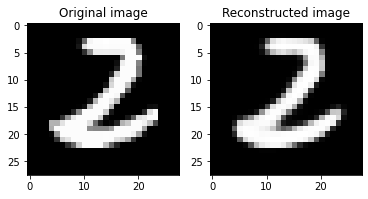

In [19]:
random_label = np.random.randint(0,9999)
img_sample = x_test[random_label,:,:].reshape((1,28,28,1))
plt.subplot(1,2,1)
plt.imshow(img_sample.reshape(28,28), cmap='gray');
plt.title('Original image');
pred_img = enc_dec.predict(img_sample) 
plt.subplot(1,2,2)
plt.imshow(pred_img.reshape(28,28), cmap='gray');
plt.title('Reconstructed image');

*A picture is worth a thousand words!* The reconstitution is very close to the original image.

In [12]:
# save models
encoder.save('encoder')
decoder.save('decoder')

In [7]:
# load models if already trained
#encoder = keras.models.load_model('encoder') 
#decoder = keras.models.load_model('decoder') 
#enc_dec = Sequential([encoder,decoder])

Now that we have a trained encoder and decoder, let's focus on the *encoder*. For each image, the encoder generates a representation that captures the most "interesting" or "important" features. This representation is sufficient to reconstitute the image using the decoder. Here is the representation of the sample image we used earlier: 

In [20]:
representation_sample = encoder.predict(img_sample)
print(representation_sample) 

[[0.6130281  0.76459074 0.6310103  0.04438157 0.10678293 0.13682882
  0.28006715 0.39419928 0.7018184  0.41447732 0.32862127 0.17540242
  0.2009563  0.3483818  0.87368184 0.35199907 0.65021783 0.46785977
  0.14121868 0.23320875 0.5732315  0.78764004 0.6864616  0.16232853
  0.77741575 0.3470657  0.6527449  0.5624531  0.6275401  0.86655647
  0.4702597  0.9197414  0.84741426 0.76422065 0.66112906 0.8598242
  0.4149059  0.12067313 0.72827107 0.9057333  0.09169123 0.785913
  0.15651442 0.8360928  0.1388307  0.18954395 0.61363137 0.4155853
  0.3886866  0.3826588  0.10800058 0.92811954 0.16767563 0.13634066
  0.6332908  0.80491865 0.3511647  0.19888486 0.07157111 0.8211692
  0.24735563 0.33792862 0.75648785 0.4793063  0.3792692  0.32980424
  0.89582556 0.4915181  0.29687124 0.62603694 0.4230361  0.35062855
  0.51796675 0.631057   0.30978802 0.7018079  0.84298    0.37712884
  0.6510555  0.90781754 0.53740066 0.26541686 0.10492547 0.28378004
  0.514947   0.8901576  0.12974055 0.5410253  0.17698

Using these 100 numbers, we generate a 28x28 image (784 pixels).

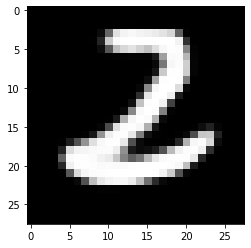

In [21]:
recons_image = decoder.predict(representation_sample)
plt.imshow(recons_image.reshape(28,28), cmap='gray');

And here is where the *fun part* begins! using the lower-dimension representation, let's do some math.

# Learning arithmetic operations on handwritten digits

The idea is simple. Using the representation of two images, we train a neural network to compute their sum, their product and to compare them. We will not provide the value of each digit, but we will provide the results during the training step.  
We will be performing addition and multiplication between numbers in the range [0-9]. The results will be in the range [0-18] and [0-81] respectively. So the results will be coded using multiple outputs:  
1- Sum **units**, multiclass output [0,1,2,3,4,5,6,7,8,9]  
2- Sum **tens**, binary output [0,1]  
3- Multiplication **units**, multiclass output [0,1,2,3,4,5,6,7,8,9]  
4- Multiplication **tens**, multiclass output [0,1,2,3,4,5,6,7,8]  
5- Comparison result, binary output [0,1]  


<p align="center"> <img src="https://i.imgur.com/E5unC7Y.png"> </p> 


Using the functional API in *KERAS* we define the network architecture. First, we import the encoder *twice* and freeze its weights:

In [15]:
# duplicate encoders and freeze weights
encoder1 = keras.models.load_model('encoder') 
encoder1._name = 'encoder1'
encoder1.trainable = False

encoder2 = keras.models.load_model('encoder')
encoder2._name = 'encoder2'
encoder2.trainable = False

Using the encoders outputs, we build the model:

In [28]:
# create model to learn it all
input1 = Input(shape=image_dim)
input2 = Input(shape=image_dim)
enc1_out = encoder1(input1)
enc2_out = encoder2(input2)
model_c = Concatenate()([enc1_out,enc2_out])
model_c = Dense(1000,activation='relu')(model_c)

model_b1 = Dense(200,activation='relu')(model_c)
model_b2 = Dense(200,activation='relu')(model_c)
model_b3 = Dense(200,activation='relu')(model_c)
model_b4 = Dense(200,activation='relu')(model_c)
model_b5 = Dense(200,activation='relu')(model_c)



units_add =  Dense(10,activation='softmax',name ='units_add')(model_b1)
tens_add = Dense(1,activation='sigmoid',name ='tens_add')(model_b2)

units_mult =  Dense(10,activation='softmax',name ='units_mult')(model_b3)
tens_mult = Dense(9,activation='softmax',name ='tens_mult')(model_b4)

comp =  Dense(1,activation='sigmoid',name ='comp')(model_b5)



model_complete = Model(inputs=[input1,input2],outputs=[units_add,tens_add,units_mult,tens_mult,comp])

model_complete.compile(optimizer='nadam', loss = ['categorical_crossentropy','binary_crossentropy','categorical_crossentropy','categorical_crossentropy','binary_crossentropy'], metrics=['acc'])

This model has two inputs (the two handwritten digits images) and five outputs (units and tens of the sum and product plus the comparsion result). We will use two different losses due to the nature of the outputs. Note that there is a common hidden layer of 1000 units, and then five branches (one for each output).  
We need to create datasets to train and test our model. Inputs will be random combinations of handwritten digits. Outputs will be the expected results for each combination. 

In [29]:
# generate a dataset for additions
train_size = 1000000
random_labels1 = np.random.randint(0,25000,train_size)
random_labels2 = np.random.randint(0,25000,train_size)

x_train_1 = x_train[random_labels1]
x_train_2 = x_train[random_labels2]

y_train_1 = y_train[random_labels1]
y_train_2 = y_train[random_labels2]

y_add = y_train_1 + y_train_2
y_add_tens = y_add //10 
y_add_units = y_add %10 
y_add_units_cat = to_categorical(y_add_units)


# the same with x_test
test_size = 5000
random_labels1 = np.random.randint(0,10000,test_size)
random_labels2 = np.random.randint(0,10000,test_size)

x_test_1 = x_test[random_labels1]
x_test_2 = x_test[random_labels2]

y_test_1 = y_test[random_labels1]
y_test_2 = y_test[random_labels2]

y_test_add = y_test_1 + y_test_2
y_test_add_tens = y_test_add //10 
y_test_add_units = y_test_add %10 
y_test_add_units_cat = to_categorical(y_test_add_units)

# generate a dataset for multiplication

y_mult = y_train_1 * y_train_2
y_mult_tens = y_mult //10 
y_mult_units = y_mult %10 
y_mult_units_cat = to_categorical(y_mult_units)
y_mult_tens_cat = to_categorical(y_mult_tens)

# the same with x_test

y_test_mult = y_test_1 * y_test_2
y_test_mult_tens = y_test_mult //10 
y_test_mult_units = y_test_mult %10 
y_test_mult_units_cat = to_categorical(y_test_mult_units)
y_test_mult_tens_cat = to_categorical(y_test_mult_tens)

# generate a dataset for comparison
y_comp = y_train_1 > y_train_2

# the same with x_test
y_test_comp = y_test_1 > y_test_2

Now we are ready to train our model! 

In [30]:
history = model_complete.fit([x_train_1,x_train_2],[y_add_units_cat,y_add_tens,y_mult_units_cat,y_mult_tens_cat,y_comp], batch_size=1000,epochs=1000,validation_split=0.2, verbose=1,callbacks=[es,es,es,es,es,es])

Epoch 1/1000
800/800 [==============================] - 87s 108ms/step - loss: 3.0021 - units_add_loss: 0.9774 - tens_add_loss: 0.2878 - units_mult_loss: 0.7837 - tens_mult_loss: 0.6782 - comp_loss: 0.2750 - units_add_acc: 0.6821 - tens_add_acc: 0.8709 - units_mult_acc: 0.7364 - tens_mult_acc: 0.7621 - comp_acc: 0.8787 - val_loss: 1.4618 - val_units_add_loss: 0.4590 - val_tens_add_loss: 0.1448 - val_units_mult_loss: 0.3579 - val_tens_mult_loss: 0.3241 - val_comp_loss: 0.1760 - val_units_add_acc: 0.8583 - val_tens_add_acc: 0.9457 - val_units_mult_acc: 0.8872 - val_tens_mult_acc: 0.8933 - val_comp_acc: 0.9290
Epoch 2/1000
800/800 [==============================] - 62s 77ms/step - loss: 0.9609 - units_add_loss: 0.3048 - tens_add_loss: 0.1016 - units_mult_loss: 0.2396 - tens_mult_loss: 0.2169 - comp_loss: 0.0980 - units_add_acc: 0.9079 - tens_add_acc: 0.9636 - units_mult_acc: 0.9261 - tens_mult_acc: 0.9308 - comp_acc: 0.9647 - val_loss: 0.6533 - val_units_add_loss: 0.2059 - val_tens_add_lo

At the end of the training, the accuracy on all outputs is pretty good (9x%). Let's see first how the model performs on the test data.

In [31]:
test = model_complete.evaluate([x_test_1,x_test_2],[y_test_add_units_cat,y_test_add_tens,y_test_mult_units_cat,y_test_mult_tens_cat,y_test_comp], batch_size=100)

50/50 [==============================] - 1s 13ms/step - loss: 0.5376 - units_add_loss: 0.1653 - tens_add_loss: 0.0632 - units_mult_loss: 0.1330 - tens_mult_loss: 0.1072 - comp_loss: 0.0688 - units_add_acc: 0.9536 - tens_add_acc: 0.9800 - units_mult_acc: 0.9626 - tens_mult_acc: 0.9678 - comp_acc: 0.9802


Results are still in the 95+% range. Let's show a random sample of the model predictions.

sum = [[10.]]
product = 16
comparison result = [[0.]] (1 if the number on the left is greater, 0 elsewhere)


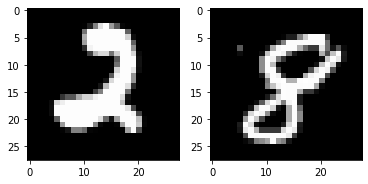

In [37]:
random_index_1 = np.random.randint(0,9999)
random_index_2 = np.random.randint(0,9999)

img_sample1 = x_test[random_index_1,:,:].reshape((1,28,28,1))
img_sample2 = x_test[random_index_2,:,:].reshape((1,28,28,1))

plt.subplot(1,2,1)
plt.imshow(img_sample1.reshape(28,28), cmap='gray');

plt.subplot(1,2,2)
plt.imshow(img_sample2.reshape(28,28), cmap='gray');

prediction = model_complete.predict([img_sample1,img_sample2])
unit_add = prediction[0]
ten_add = prediction[1]
unit_mult = prediction[2]
ten_mult = prediction[3]
comp_images = prediction[4]

sum_images = np.argmax(unit_add)+10*np.round(ten_add)
print('sum =',sum_images)


mult_images = np.argmax(unit_mult)+10*np.argmax(ten_mult)
print('product =',mult_images)

print('comparison result =',np.round(comp_images),'(1 if the number on the left is greater, 0 elsewhere)')

We could improve the accuracy by training the model on more random samples (increase `train_size` value) or tweak the model architecture. With that being said, we managed to build a neural network that is capable of solving basic arithmetic operations on handwritten digits *without* explicitly computing their values.

In [33]:
# save the model
model_complete.save('model_complete')

# Conclusion and future work

In this post, we designed an autoencoder that we trained on MNIST images. A neural network, based on the autoencoder was trained to perform arithmetic operations. During the autoencoder training, the **encoder** learns the most important features of the images, in order to reconstruct them later via the **decoder**. These features can be used in further operations (usually using dense or recurrent layers). We achieved more than 95% accuracy on all outputs.  

Autoencoders are part of unsupervised learning. We are still scratching the surface of these amazing machine learning techniques. I will continue to explore this area, especially using recurrent neural networks and their applications in natural language processing and time series.  

# References

The notebook [https://jovian.ai/kara-mounir/mnist_autoencoder]  

Machine learning mastery blog by Jason Brownlee [https://machinelearningmastery.com]  

My Github [https://github.com/zaitrik]  

My LinkedIn [https://www.linkedin.com/in/mounir-kara-zaitri-a01a00208/]